<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

Today, I'd like to introduce you to the automatic differentiation component of my deep learning framework, Minima. I am going to explain a specific module, called Micrograd, in detail. I had released the Micrograd module on Github a couple of years ago, but never provided an in-depth explanation of its functioning. So here we go.

Micrograd, at its core, is an autograd (short for automatic gradient) engine. It implements the backpropagation algorithm, a crucial aspect of deep learning. Backpropagation enables efficient computation of the gradient (rate of change) of a loss function (something we aim to minimize) with respect to the weights of a neural network. This enables us to fine-tune the weights of the neural network iteratively, reducing the loss function, and in turn, increasing the accuracy of the network. Backpropagation is central to most modern deep neural network libraries, such as PyTorch or Jax.

To help illustrate what Micrograd does, consider a simple example. We start with two inputs, a and b, encapsulated in special objects we call "Value" objects. We then construct a mathematical expression involving a and b. The Value objects help Micrograd to keep track of how these inputs are being transformed, and the operations performed on them, resulting in a complete mathematical "expression graph".

Micrograd then performs two key tasks. First, it carries out a 'forward pass' - it evaluates the final value of the expression we've created. But more importantly, it then performs a 'backward pass' - essentially a run of the backpropagation algorithm. It starts from the final value and traces back through the expression graph, calculating the derivative (rate of change) of the final value with respect to each of the original inputs and intermediate nodes, using the chain rule of calculus.

This is crucial as these derivatives tell us how much our final value is affected by small changes in the inputs. In essence, the derivative of the final value with respect to an input is a measure of the "sensitivity" of the final value to that input.

Now, the example above might seem abstract - the expression we constructed didn't have any particular meaning, it was just a demonstration of the capabilities of Micrograd. But the reason it's useful is that this kind of mathematical expression is exactly what neural networks are - they take input data and network weights as inputs, and transform them through a series of mathematical operations into a final output, usually a prediction or a loss value.

One thing to note here is that Micrograd operates at the level of individual scalar values, not n-dimensional tensors as you'd typically find in full-scale deep learning libraries. This is for simplicity and instructional clarity. In real-world, high-performance neural network libraries, tensors are used to bundle up large arrays of scalar values, enabling efficient, parallel computation. But fundamentally, the math stays the same.

So, what's the magic behind Micrograd? Surprisingly, the core autograd engine, the part that handles backpropagation and makes neural network training possible, is a mere 100 lines of simple Python code. On top of that, the neural network library, constructed based on this autograd engine, is only an additional 50 lines of code. It's pretty impressive how much power you can get from just a handful of well-written Python code lines.

All of this is to say, understanding automatic differentiation and neural network training doesn't require an enormous, complicated codebase. It's essentially about understanding a relatively small number of key concepts and how they work together. Of course, making these things run fast and efficiently in practice does require additional complexity, but at a fundamental level, what's happening isn't that complicated. And Micrograd serves as an excellent tool for understanding these fundamentals. Now,

## Derivatives

In calculus, the derivative of a function at a certain point is a measure of how the function changes at that point. It is defined as the limit of the ratio of the change in the function value (`f(x)`) to the change in the `x` value (`Δx`) as `Δx` approaches zero. This can be written as:


$$f'(x) = \lim_{{Δx \to 0}} \frac{{f(x + Δx) - f(x)}}{{Δx}}$$


This equation represents the slope of the tangent line to the function at a specific point `x`, which can also be interpreted as the instantaneous rate of change of the function at that point.

If you have a function `y = f(x) = x^n`, where `n` is a constant, the power rule of differentiation tells us that the derivative of `f(x)` with respect to `x` is:


$$f'(x) = n * x^{n-1}$$

In the context of the function `d = a*b + c` which we're going to use below, since `a` is the variable and `b` and `c` are constants, the derivative of `d` with respect to `a` is just `b`. This can be written in LaTeX as:

$$ \frac{{dd}}{{da}} = b $$

we begin by assigning values to three variables `a`, `b`, and `c`. We then create a fourth variable, `d`, which is equal to the product of `a` and `b`, added to `c`. When you execute this cell, it should display the value of `d`.

In [4]:
a = 4
b = -2
c = 11
d = a*b + c
d

3

 we define a function `f_a(a,b,c)`, which helps us estimate the slope of the function at the point `a`. The function first calculates `d1` using the given inputs, `a`, `b`, and `c`. Then it increments `a` by a small value `h` and recalculates the value `d2`. The function then prints the original `d1`, the new `d2`, and the estimated slope which is `(d2 - d1) / h`.

In [5]:
def f_a(a,b,c):
    h = 0.01
    d1 = a*b + c
    a += h
    d2 = a*b + c
    
    print(f'd1: {d1}')
    print(f'd2: {d2}')
    print(f'slope: {(d2 - d1) / h}')
    
f_a(a,b,c)

d1: 3
d2: 2.9800000000000004
slope: -1.9999999999999574


that states that the derivative of `d` with respect to `a`, denoted as `(db/da)`, is analytically equal to `b`. This is because in the expression `d = a*b + c`, the coefficient of `a` is `b`, so by the power rule of differentiation, the derivative is `b`. In this case, `b` equals `-2`.

Now if we do this with `b`

In [6]:
def f_b(a,b,c):
    h = 0.01
    d1 = a*b + c
    b += h
    d2 = a*b + c
    
    print(f'd1: {d1}')
    print(f'd2: {d2}')
    print(f'slope: {(d2 - d1) / h}')
    
f_b(a,b,c)

d1: 3
d2: 3.04
slope: 4.0000000000000036


Here's what happens in the function:
1. It begins by defining a small change `h` which is set to `0.01`.
2. Then, the function calculates `d1`, which is the result of `a*b + c` with the original inputs `a`, `b`, and `c`.
3. It increments `b` by the small value `h`.
4. Next, the function calculates a new `d2`, which is the result of `a*b + c` after the increment to `b`.
5. Finally, the function prints out the original `d1`, the new `d2`, and the estimated slope calculated as `(d2 - d1) / h`.

When you call `f_b(a,b,c)`, the function performs all these operations using the values of `a`, `b`, and `c` from the previous context.

The output will give you an approximate value of the derivative of `d` with respect to `b` (noted as `dd/db` in mathematical notation), assuming that the function `d(a, b, c) = a*b + c` is relatively smooth and continuous near the point `b`.

## Derivatives in the context of neural nets (Autograd)

Automatic differentiation, or auto grad as it's often referred to in the context of deep learning, is a powerful tool that greatly simplifies the process of working with derivatives. It does this by automatically computing the derivatives (or gradients) of functions, thus relieving the need to manually calculate these derivatives as we have done above.

The use of auto grad is fundamental to the training process of deep learning models. Deep learning models, such as neural networks, are essentially complex mathematical functions with many parameters (weights and biases). Training these models involves adjusting these parameters to minimize a loss function, which quantifies how well the model is performing on a given task. The most common method for doing this is gradient descent, which uses the gradients of the loss function with respect to the parameters to update the parameters in a way that decreases the loss.

However, the manual calculation of these gradients, especially for complex models, is not only tedious but also prone to errors. Here's where auto grad comes in. By using automatic differentiation, we can compute these gradients automatically and accurately, no matter how complex the model is.

In a deep learning framework, when we define our model and loss function, the framework uses auto grad to build a computational graph under the hood. This graph captures all the computations that are done in the forward pass (i.e., when we pass our inputs through the model to get the output). Then, when we need to compute the gradients during the backward pass, the framework uses this computational graph and the chain rule from calculus to compute the gradients automatically. This process is often referred to as backpropagation.

The main advantage of using auto grad in deep learning is that it allows us to focus on designing our models and defining our loss functions without worrying about the details of computing the gradients. This simplifies our code, reduces the chance of errors, and allows for greater flexibility in designing complex models. In fact, with auto grad, we can easily experiment with new types of models and loss functions, as we can rely on the framework to correctly compute the gradients no matter how complex our design is.

Let's start building a mini autograd engine

In [7]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s data %.4f | grad %.4f }" % (n.label, n._data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In the context of deep learning and automatic differentiation, the Value class is designed to encapsulate a scalar value and its relationships within a computational graph. This abstraction is essential for constructing mathematical expressions from basic operations and for performing the forward pass, which evaluates the expression.

The Value class is initialized with data and optional parameters specifying its children (or dependencies) and the operation that produced it. Each instance of the Value class can have a gradient, which is initialized as zero and can be updated during backpropagation.

Two fundamental operations are implemented for instances of the Value class: addition (__add__) and multiplication (__mul__). These methods allow two Value instances (or a Value and a scalar) to be added or multiplied, respectively. The results of these operations are also Value instances, maintaining the relationships in the computational graph.

This ability to build out mathematical expressions using only addition and multiplication allows for the construction of a broad variety of functions. For example, given multiple inputs (a, b, c, f), we can formulate a mathematical expression that generates a single output (l). After the forward pass, the output value is calculated and can be visualized, as demonstrated in the example where the forward pass output is -8.

In summary, the Value class is a fundamental building block for creating and navigating a computational graph in the context of automatic differentiation, making it an invaluable tool in any deep learning framework.

In [1]:
#| echo: false
#| output: asis
show_doc(Value)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L170){target="_blank" style="float:right; font-size:smaller"}

### Value

>      Value (data, _children=(), _op='', label='')

Represents a node within a computational graph.

This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
differentiation within deep learning frameworks.

Attributes:
    op (Operator)
    _prev (Set['Value']) 
    cached_data (NDArray)
    requires_grad (bool)

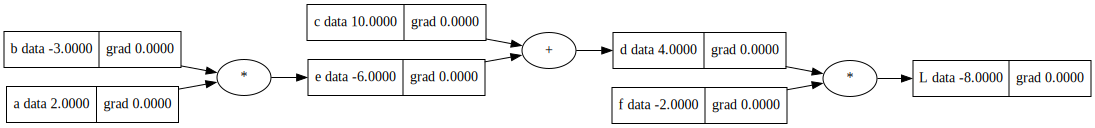

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

The code provided builds upon the previously discussed [`Value`](https://m0saan.github.io/minima/autograd.html#value) class, which acts as a node within a computational graph in the context of automatic differentiation. It demonstrates how to define scalar values `a`, `b`, `c`, and `f` and use them to build a computational graph. The graph computes the expression `L = (a * b + c) * f`, represented in nodes labeled 'e', 'd', and 'L'.

The focus of this explanation is the process of backpropagation and the computation of gradients for every node in the graph, which is crucial for training neural networks. In a neural network setting, the loss function `L` would typically be calculated with respect to the network's weights. Here, these weights are abstractly represented by the scalar variables `a`, `b`, `c`, and `f`.

The fundamental idea behind backpropagation is to compute the derivative of the output value `L` with respect to every node in the graph. These derivatives represent the impact each node has on the final output. They are stored in the `grad` attribute of the [`Value`](https://m0saan.github.io/minima/autograd.html#value) class, which is initialized to zero, signifying that there is initially no effect on the output.

In this context, a gradient of zero means changing the value of a node has no effect on the final output, or loss function. After performing backpropagation, the `grad` attribute will store the actual derivative of `L` with respect to that node. This is essential information when training a neural network because it dictates how to adjust the weights (in this example, `a`, `b`, `c`, and `f`) to minimize the loss function `L`.

The function `draw_dot(L)` is presumably used to visualize this computational graph, including both the `data` and the `grad` of each node. This visualization aids in understanding the forward and backward passes of computation within the graph.

In conclusion, this code snippet creates a simple computational graph using the [`Value`](https://m0saan.github.io/minima/autograd.html#value) class, computes a mathematical expression, and prepares for backpropagation. The next steps would involve the actual calculation of the gradients, enabling the iterative optimization of weights based on their influence on the final output.

## Manual gradient

### base case (`L grad`)

In [10]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L' 
    
    L2 = L.data + h
    
    print(f'grad: {(L2 - L1) / h}')

lol()

grad: 1.000000000000334


sure enough it's 1

In [11]:
L.grad = 1

####  f

Here is a generic version of `lol`

In [12]:
def lol(label):
    def foo(v, label):
        if v.label == label: v.data += h
        
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    
    L1 = L.data
    
    a = Value(2.0, label='a'); foo(a, label)
    b = Value(-3.0, label='b'); foo(b, label)
    c = Value(10.0, label='c'); foo(c, label)
    e = a*b; e.label='e'; foo(e, label)
    d = e + c; d.label='d'; foo(d, label)
    f = Value(-2.0, label='f'); foo(f, label)
    L = d*f; L.label='L'; foo(L, label) 
    
    L2 = L.data
    
    print(f'grad: {(L2 - L1) / h}')

lol('f')

grad: 3.9999999999995595


In [13]:
f.grad = 4

In [14]:
lol('d')

grad: -2.000000000000668


In [15]:
d.grad = -2

Let's draw what we have up to this point

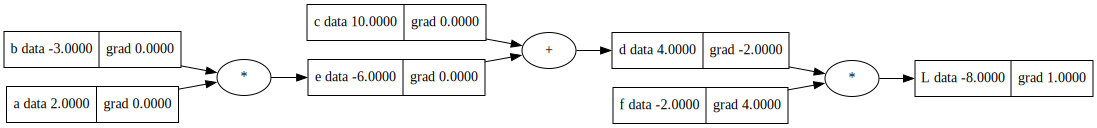

In [16]:
draw_dot(L)

Sure, here's the step by step derivation for each of the variables:

1. With respect to `a`:

Given that `L = (a*b + c) * f`, we will apply the product rule for differentiation.

The derivative of `a*b` with respect to `a` is `b`, and the derivative of `c` with respect to `a` is `0`. Therefore:

$$
\frac{dL}{da} = f \cdot \frac{d(a*b + c)}{da} = f \cdot (b + 0) = b \cdot f
$$

2. With respect to `b`:

The derivative of `a*b` with respect to `b` is `a`, and the derivative of `c` with respect to `b` is `0`. Therefore:

$$
\frac{dL}{db} = f \cdot \frac{d(a*b + c)}{db} = f \cdot (a + 0) = a \cdot f
$$

3. With respect to `c`:

The derivative of `a*b` with respect to `c` is `0`, and the derivative of `c` with respect to `c` is `1`. Therefore:

$$
\frac{dL}{dc} = f \cdot \frac{d(a*b + c)}{dc} = f \cdot (0 + 1) = f
$$

4. With respect to `f`:

The derivative of `(a*b + c)` with respect to `f` is `0`, and `f` is just `f`, therefore:

$$
\frac{dL}{df} = (a*b + c) \cdot \frac{df}{df} = a*b + c
$$

5. With respect to `e` (where `e = a*b`):

The derivative of `e + c` with respect to `e` is `1`. Therefore:

$$
\frac{dL}{de} = f \cdot \frac{d(e + c)}{de} = f \cdot 1 = f
$$

6. With respect to `d` (where `d = e + c`):

The derivative of `d` with respect to `d` is `1`. Therefore:

$$
\frac{dL}{dd} = f \cdot \frac{df}{df} = f
$$

In [17]:
lol('e')

grad: -2.000000000000668


In [18]:
e.grad = -2 # 1 * d.grad

In [19]:
lol('c')

grad: -1.9999999999988916


In [20]:
c.grad = -2 # 1 * d.grad

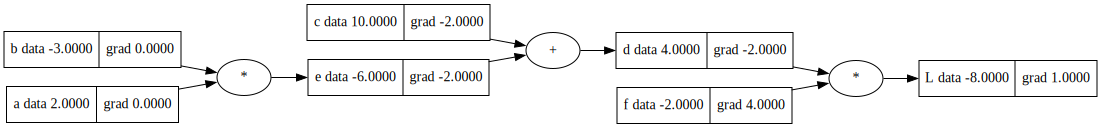

In [21]:
draw_dot(L)

In [22]:
lol('a')

grad: 6.000000000000227


In [23]:
a.grad = 6  # b * e.grad

In [24]:
lol('b')

grad: -3.9999999999995595


In [25]:
b.grad = -4 # a * e.grad

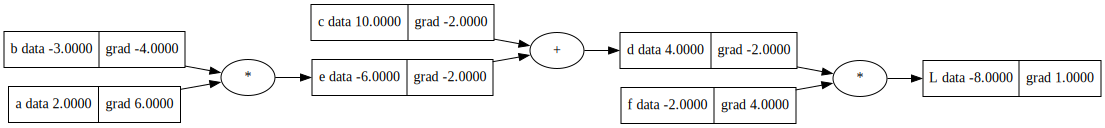

In [26]:
draw_dot(L)

In [2]:
#| echo: false
#| output: asis
show_doc(Value)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L170){target="_blank" style="float:right; font-size:smaller"}

### Value

>      Value (data, _children=(), _op='', label='')

Represents a node within a computational graph.

This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
differentiation within deep learning frameworks.

Attributes:
    op (Operator)
    _prev (Set['Value']) 
    cached_data (NDArray)
    requires_grad (bool)

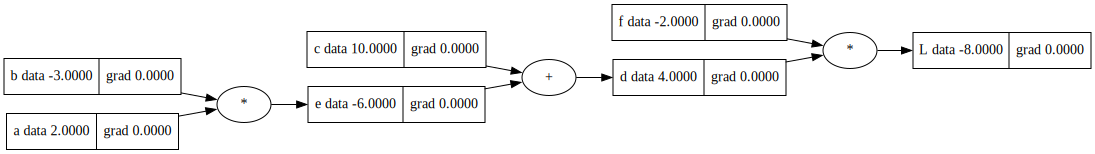

In [28]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

In [29]:
L.grad = 1

In [30]:
L._backward()

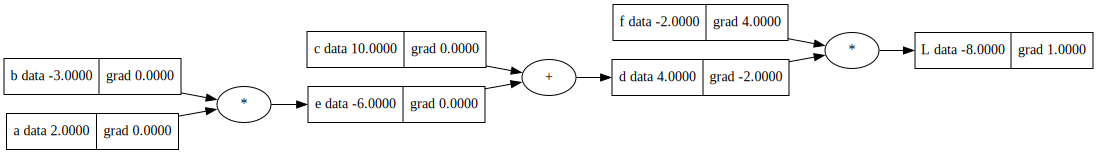

In [31]:
draw_dot(L)

In [32]:
d._backward()

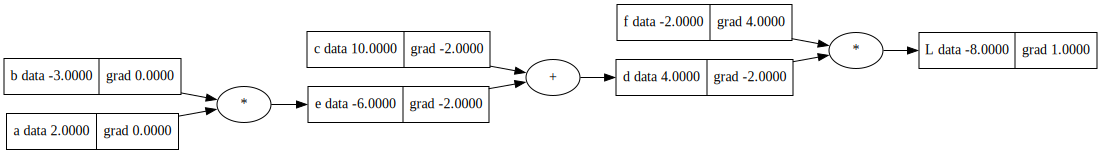

In [33]:
draw_dot(L)

In [34]:
c._backward()

We expect that nothing will happen

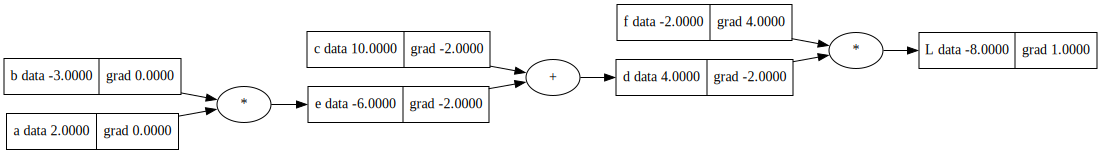

In [35]:
draw_dot(L)

In [36]:
e._backward()

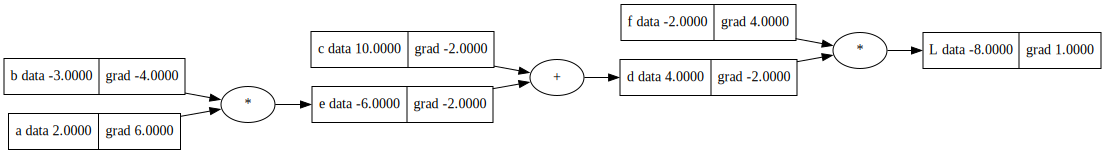

In [37]:
draw_dot(L)

sure enough, exactly as we did before

We can do thid process automatically using topo sort algorithms, which's will give us the correct order on which to call _backward on

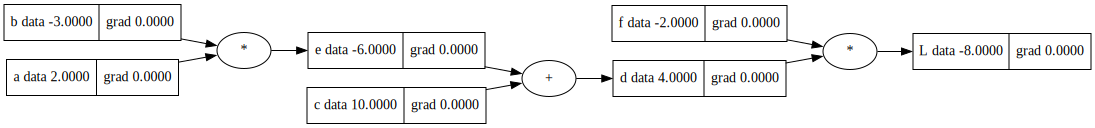

In [38]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

In [39]:
# topological order all of the children in the graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(L)

In [40]:
topo

[Value(data=10.0, grad=0),
 Value(data=-3.0, grad=0),
 Value(data=2.0, grad=0),
 Value(data=-6.0, grad=0),
 Value(data=4.0, grad=0),
 Value(data=-2.0, grad=0),
 Value(data=-8.0, grad=0)]

In [41]:
# go one variable at a time and apply the chain rule to get its gradient
L.grad = 1
for v in reversed(topo):
    v._backward()

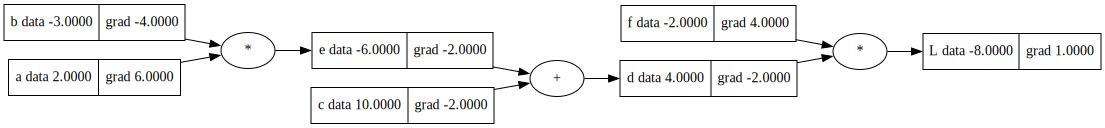

In [42]:
draw_dot(L)

So let's now update the Value class with this logic

In [3]:
#| echo: false
#| output: asis
show_doc(Value)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L170){target="_blank" style="float:right; font-size:smaller"}

### Value

>      Value (data, _children=(), _op='', label='')

Represents a node within a computational graph.

This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
differentiation within deep learning frameworks.

Attributes:
    op (Operator)
    _prev (Set['Value']) 
    cached_data (NDArray)
    requires_grad (bool)

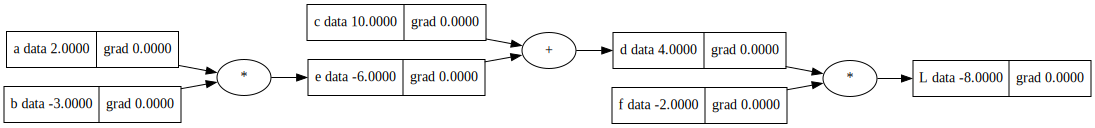

In [44]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L' 

draw_dot(L)

In [45]:
L.backward()

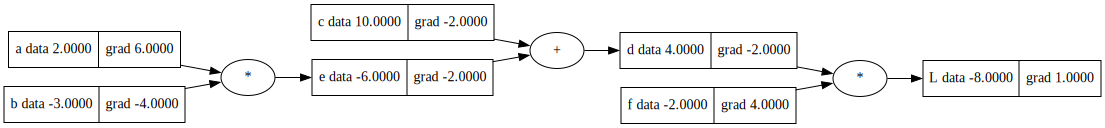

In [46]:
draw_dot(L)

In [4]:
#| echo: false
#| output: asis
show_doc(Value)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L170){target="_blank" style="float:right; font-size:smaller"}

### Value

>      Value (data, children=(), op='', label='')

A class representing a scalar value and its gradient in a computational graph.

Attributes:
- data (float): the scalar value associated with this node
- grad (float): the gradient of the output of the computational graph w.r.t. this node's value
- label (str): a label for this node, used for debugging and visualization purposes
- _op (str): a string representation of the operation that produced this node in the computational graph
- _prev (set of Value objects): the set of nodes that contributed to the computation of this node
- _backward (function): a function that computes the gradients of this node w.r.t. its inputs

Methods:
- __init__(self, data, children=(), op='', label=''): Initializes a Value object with the given data, children, op, and label
- __repr__(self): Returns a string representation of this Value object
- __add__(self, other): Implements the addition operation between two Value objects
- __mul__(self, other): Implements the multiplication operation between two Value objects
- item(self): Returns the scalar value associated with this Value object
- tanh(self): Applies the hyperbolic tangent function to this Value object and returns a new Value object

In [5]:
#| echo: false
#| output: asis
show_doc(all_devices)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L508){target="_blank" style="float:right; font-size:smaller"}

### all_devices

>      all_devices ()

return a list of all available devices

In [6]:
#| echo: false
#| output: asis
show_doc(cpu)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L504){target="_blank" style="float:right; font-size:smaller"}

### cpu

>      cpu ()

Return cpu device

In [7]:
#| echo: false
#| output: asis
show_doc(CPUDevice)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L489){target="_blank" style="float:right; font-size:smaller"}

### CPUDevice

>      CPUDevice ()

Represents data that sits in CPU

In [8]:
#| echo: false
#| output: asis
show_doc(Device)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L485){target="_blank" style="float:right; font-size:smaller"}

### Device

>      Device ()

Indicates the device supporting an NDArray.

In [9]:
#| echo: false
#| output: asis
show_doc(Operator)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L513){target="_blank" style="float:right; font-size:smaller"}

### Operator

>      Operator ()

Initialize self.  See help(type(self)) for accurate signature.

In [10]:
#| echo: false
#| output: asis
show_doc(TensorOp)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L525){target="_blank" style="float:right; font-size:smaller"}

### TensorOp

>      TensorOp ()

Op class specialized to output tensors, will be alternate subclasses for other structures

``` python
#| export
class Value:
    """
    Represents a node within a computational graph.

    This class encapsulates a single value and its relationships in the graph, making it easy to track and manage the value's dependencies, 
    the operation that produced it, and whether it requires a gradient for backpropagation. It's central to the functioning of automatic 
    differentiation within deep learning frameworks.

    Attributes:
        op (Operator)
        _prev (Set['Value']) 
        cached_data (NDArray)
        requires_grad (bool)
    """
    def __init__(self,
                 op: Operator, # The operator that produced this node. If the node was initialized from actual data, this is 'None'.
                 prev: Set['Value'], # The set of values that this value directly depends on. It's the union of the `_next` sets of all the values in `args`.
                 cached_data: NDArray, # The actual data for this value. It's `None` for values that aren't yet computed.
                 requires_grad: bool): # Specifies whether this node requires a gradient. This is `False` for nodes that don't need gradients.
        
        self._op = op
        self._prev = op
        self.cached_data = cached_data
        self.requires_grad = requires_grad
```

In [11]:
#| echo: false
#| output: asis
show_doc(Tensor)

---

[source](https://github.com/m0saan/minima/blob/main/minima/autograd.py#L532){target="_blank" style="float:right; font-size:smaller"}

### Tensor

>      Tensor (array, device:Optional[__main__.Device]=None, dtype=None,
>              requires_grad=True, **kwargs)

A Tensor represents a multidimensional array of values in a computational graph.

Attributes:
- data: The actual data of the tensor. It is computed lazily.
- children: Other tensors that this tensor depends on for computing its value.
- requires_grad: Whether this tensor needs to compute gradients.

Methods:
- realize_data: Computes and returns the actual data for this tensor.
- shape: Returns the shape of this tensor.
- dtype: Returns the data type of this tensor.

Example:
>>> t1 = Tensor([[1.0, 2.0], [3.0, 4.0]])
>>> print(t1.shape)
(2, 2)
>>> print(t1.dtype)
float64

In [54]:
import numpy as np
import unittest
from minima.autograd import Tensor

class TestTensor(unittest.TestCase):
    
    def test_create_tensor(self):
        t1 = Tensor([1, 2, 3])
        self.assertTrue(np.array_equal(t1.realize_data(), np.array([1, 2, 3])))
        self.assertEqual(t1.shape, (3,))
        self.assertEqual(t1.dtype, np.float64)
        
        t2 = Tensor([[1, 2], [3, 4]])
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([[1, 2], [3, 4]])))
        self.assertEqual(t2.shape, (2, 2))
        self.assertEqual(t2.dtype, np.float64)
        
        t3 = Tensor(np.array([1, 2, 3]), dtype=np.int32)
        self.assertTrue(np.array_equal(t3.realize_data(), np.array([1, 2, 3], dtype=np.int32)))
        self.assertEqual(t3.shape, (3,))
        self.assertEqual(t3.dtype, np.int32)
        
    def test_create_tensor_from_tensor(self):
        t1 = Tensor([1, 2, 3])
        t2 = Tensor(t1)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3])))
        self.assertEqual(t2.shape, (3,))
        self.assertEqual(t2.dtype, np.float64)
        
        t3 = Tensor(np.array([1, 2, 3]), dtype=np.int32)
        t4 = Tensor(t3)
        self.assertTrue(np.array_equal(t4.realize_data(), np.array([1, 2, 3], dtype=np.int32)))
        self.assertEqual(t4.shape, (3,))
        self.assertEqual(t4.dtype, np.int32)
        
    def test_create_tensor_with_device(self):
        t1 = Tensor([1, 2, 3], device='cpu')
        self.assertEqual(t1.device, 'cpu')
        
        t2 = Tensor([1, 2, 3], device='cuda')
        self.assertEqual(t2.device, 'cuda')
        
    def test_create_tensor_with_requires_grad(self):
        t1 = Tensor([1, 2, 3], requires_grad=True)
        self.assertTrue(t1.requires_grad)
        
        t2 = Tensor([1, 2, 3], requires_grad=False)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_with_kwargs(self):
        t1 = Tensor([1, 2, 3], device='cuda', dtype=np.float32, requires_grad=True)
        self.assertEqual(t1.device, 'cuda')
        self.assertEqual(t1.dtype, np.float32)
        self.assertTrue(t1.requires_grad)
        
    def test_create_tensor_from_numpy(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array)
        self.assertTrue(np.array_equal(t1.realize_data(), np_array))
        self.assertEqual(t1.shape, (3,))
        self.assertEqual(t1.dtype, np.float64)
        
        np_array = np.array([1, 2, 3], dtype=np.int32)
        t2 = Tensor(np_array)
        self.assertTrue(np.array_equal(t2.realize_data(), np_array))
        self.assertEqual(t2.shape, (3,))
        self.assertEqual(t2.dtype, np.int32)
        
    def test_create_tensor_from_numpy_with_device(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array, device='cuda')
        self.assertEqual(t1.device, 'cuda')
        
        np_array = np.array([1, 2, 3], dtype=np.int32)
        t2 = Tensor(np_array, device='cuda')
        self.assertEqual(t2.device, 'cuda')
        
    def test_create_tensor_from_numpy_with_requires_grad(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array, requires_grad=True)
        self.assertTrue(t1.requires_grad)
        
        np_array = np.array([1, 2, 3], dtype=np.int32)
        t2 = Tensor(np_array, requires_grad=False)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_numpy_with_kwargs(self):
        np_array = np.array([1, 2, 3])
        t1 = Tensor(np_array, device='cuda', dtype=np.float32, requires_grad=True)
        self.assertEqual(t1.device, 'cuda')
        self.assertEqual(t1.dtype, np.float32)
        self.assertTrue(t1.requires_grad)
        
    def test_create_tensor_from_tensor_with_device(self):
        t1 = Tensor([1, 2, 3], device='cpu')
        t2 = Tensor(t1, device='cuda')
        self.assertEqual(t2.device, 'cuda')
        
    def test_create_tensor_from_tensor_with_requires_grad(self):
        t1 = Tensor([1, 2, 3], requires_grad=True)
        t2 = Tensor(t1, requires_grad=False)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_kwargs(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32)
        t2 = Tensor(t1, device='cuda', dtype=np.float64)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32)
        t2 = Tensor(t1, device='cpu', dtype=np.float32)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=True)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=False)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_same_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cpu', dtype=np.float32, requires_grad=True)
        self.assertEqual(t2.device, 'cpu')
        self.assertEqual(t2.dtype, np.float32)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float32)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=True)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertTrue(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_true_false(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=True)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=False)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertFalse(t2.requires_grad)
        
    def test_create_tensor_from_tensor_with_different_device_and_dtype_and_requires_grad_false_true(self):
        t1 = Tensor([1, 2, 3], device='cpu', dtype=np.float32, requires_grad=False)
        t2 = Tensor(t1, device='cuda', dtype=np.float64, requires_grad=True)
        self.assertEqual(t2.device, 'cuda')
        self.assertEqual(t2.dtype, np.float64)
        self.assertTrue(np.array_equal(t2.realize_data(), np.array([1, 2, 3], dtype=np.float64)))
        self.assertTrue(t2.requires_grad)

In [55]:
import nbdev; nbdev.nbdev_export()